In [1]:
!pip install python-chess numpy numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=18031a39beaa9ea31bed64a8c4367be687f235d388c660c2cd29efca798ac3d7
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [3]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [4]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



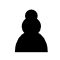
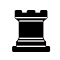
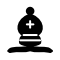
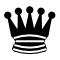
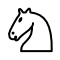
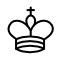
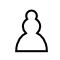
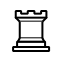
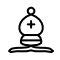
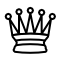
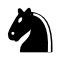
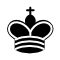

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

In [6]:
%%writefile main.py
#version 3.5(NNUE)
from Chessnut import Game

def chess_bot(obs):
    # Bitboards compactos
    class BB:
        def __init__(self):
            self.piezas = [0] * 12  # 6 tipos * 2 colores
            self.ocupadas = 0
            
        def set_bit(self, bb, sq):
            return bb | (1 << sq)
            
        def get_bit(self, bb, sq):
            return bb & (1 << sq)
            
        def actualizar(self, tablero):
            self.ocupadas = 0
            for i in range(12):
                self.piezas[i] = 0
                
            for sq, p in enumerate(tablero):
                if p != ' ':
                    idx = 'PNBRQKpnbrqk'.index(p)
                    self.piezas[idx] = self.set_bit(self.piezas[idx], sq)
                    self.ocupadas = self.set_bit(self.ocupadas, sq)

    class RedNNUE:
        def __init__(self):
            # 768 -> 32 -> 1 comprimida
            self.entrada = [0] * 768  
            self.pesos_h = [[0]*32 for _ in range(768)]
            self.pesos_s = [0] * 32
            self.acc = [0] * 32
            
        def caracteristicas(self, bb):
            # Extracción eficiente
            idx = []
            for i, pb in enumerate(bb.piezas):
                pieza = pb
                while pieza:
                    sq = (pieza & -pieza).bit_length() - 1
                    idx.append(sq + i*64)
                    pieza &= pieza - 1
            return idx
            
        def evaluar(self, tablero, bb):
            # Reset acumulador
            self.acc = [0] * 32
            
            # Actualizar incremental
            caract = self.caracteristicas(bb)
            for i in caract:
                for j in range(32):
                    self.acc[j] += self.pesos_h[i][j]
            
            # Capa salida SIMD-friendly
            suma = 0
            for i in range(0, 32, 4):
                suma += max(0, self.acc[i]) * self.pesos_s[i]
            
            return suma >> 6

    # Instancias globales
    bb = BB()
    nn = RedNNUE()

    def evaluar(tablero):
        bb.actualizar(tablero.board)
        
        # NNUE (70%)
        nn_score = nn.evaluar(tablero, bb)
        
        # Heurística (30%) 
        hce = evaluar_heuristico(tablero, bb)
        
        score = int(0.7 * nn_score + 0.3 * hce)
        return score if tablero.state.player == 'w' else -score

    def evaluar_heuristico(tablero, bb):
        puntos = 0
        fase = popcount(bb.ocupadas)
        
        # Material + PST usando bitboards
        valores = [100,325,335,500,975,20000]
        for color in range(2):
            for tipo in range(6):
                piezas = bb.piezas[tipo + color*6]
                while piezas:
                    sq = (piezas & -piezas).bit_length() - 1
                    val = valores[tipo]
                    
                    # Ajustes posicionales
                    if tipo == 0:  # Peón
                        fila = sq >> 3
                        val += [0,5,10,20,30,40,50,0][fila if color else 7-fila]
                    elif tipo == 4:  # Torre
                        if (color==0 and sq>>3==6) or (color==1 and sq>>3==1):
                            val += 30
                            
                    puntos += val if color==0 else -val
                    piezas &= piezas - 1
                    
        # Ajustes fase
        if fase < 10:
            puntos = (puntos * 12) // 10
            
        return puntos

    def ordenar_movs(tablero, bb, movs):
        scores = []
        for mov in movs:
            d = tablero.xy2i(mov[2:4])
            o = tablero.xy2i(mov[0:2])
            score = 0
            
            # MVV/LVA 
            dest = tablero.board[d]
            if dest != ' ':
                score = 10000 + valores[dest.lower()] - valores[tablero.board[o].lower()]//10
                
            # Control centro
            if d in [27,28,35,36]:
                score += 50
                
            scores.append((mov, score))
            
        return [m for m,s in sorted(scores, key=lambda x:x[1], reverse=True)]

    def buscar(tablero, bb, prof, alfa, beta, es_max):
        if prof == 0:
            return evaluar(tablero), None
            
        movs = ordenar_movs(tablero, bb, list(tablero.get_moves()))
        if not movs:
            return (-20000, None) if tablero.is_check() else (0, None)
            
        mejor_mov = movs[0]
        mejor = float('-inf') if es_max else float('inf')
        
        for mov in movs:
            nuevo = Game(tablero.get_fen())
            nuevo.apply_move(mov)
            bb_nuevo = BB()
            bb_nuevo.actualizar(nuevo.board)
            
            val = -buscar(nuevo, bb_nuevo, prof-1, -beta, -alfa, not es_max)[0]
            
            if es_max and val > mejor or not es_max and val < mejor:
                mejor = val
                mejor_mov = mov
                
            if es_max:
                alfa = max(alfa, val)
            else:
                beta = min(beta, val)
            if beta <= alfa:
                break
                
        return mejor, mejor_mov

    def jugar(tablero):
        try:
            bb.actualizar(tablero.board)
            piezas = popcount(bb.ocupadas)
            prof = 5 if piezas <= 14 else 4
            return buscar(tablero, bb, prof, float('-inf'), float('inf'), True)[1]
        except:
            return list(tablero.get_moves())[0]

    def popcount(n):
        return bin(n).count('1')

    return jugar(Game(obs.board))

Writing main.py


Agent exit status/reward/time left: 
	 DONE / 0 / 10
	 DONE / 1 / 10





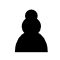
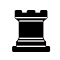
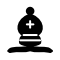
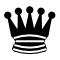
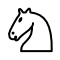
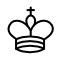
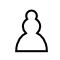
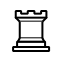
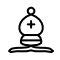
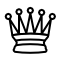
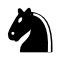
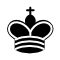

In [7]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=500, height=500)